# Quickstart (2 minutes)
1. **Run the Setup cell** below (installs/imports). If prompted in Colab, allow the notebook to use the GPU (not required, but nice).
2. **Run the Data cell** to fetch fsaverage & the sample stat map.
3. Jump to **Part 2** (surface) and **Part 3** (slice viewer) for instant wins.


# In this notebook we will cover:#
- Quickstart + check versions
- Surface plot demo
- Slice viewer
- 3D Connectome + widgets/fallback
- Upload your own


# ESMRMB 2025: Interactive Brain Visualizations

**Goal:** learn quick, reproducible ways to make interactive brain visualizations in Python (works in Google Colab).

**What you'll do**
1. Install tools and fetch example data
2. Make an interactive 3D cortical surface map with Plotly
3. Explore a statistical map with an interactive slice viewer
4. Build up a simulated 3D connectome in Plotly
5. Upload & visualize your own NIfTI

> Tip: Run each cell in order. If you're in **Colab**, make sure the first cell (installs) finishes before moving on.


In [1]:
# --- Helpers: environment check, HTML export, robust percentiles ---
import sys, platform, json
from typing import Tuple

def check_env():
    """Print helpful env info (Python, OS, key libs) for debugging."""
    info = {
        "python": sys.version.split()[0],
        "platform": platform.platform(),
    }
    try:
        import nilearn, nibabel, plotly, ipywidgets
        info.update({
            "nilearn": getattr(nilearn, "__version__", "unknown"),
            "nibabel": getattr(nibabel, "__version__", "unknown"),
            "plotly": getattr(plotly, "__version__", "unknown"),
            "ipywidgets": getattr(ipywidgets, "__version__", "unknown"),
        })
    except Exception:
        pass
    print(json.dumps(info, indent=2))

def write_html(fig, path="figure.html"):
    """Save a Plotly figure to a standalone HTML file (easy to share)."""
    return fig.write_html(path, include_plotlyjs="cdn")

def robust_percentiles(arr, lo=90, hi=99):
    """Return (p_lo, p_hi) ignoring NaNs; fallback to min/max if needed."""
    import numpy as np
    data = np.asarray(arr)
    finite = data[np.isfinite(data)]
    if finite.size == 0:
        return 0.0, 1.0
    p_lo = float(np.nanpercentile(finite, lo))
    p_hi = float(np.nanpercentile(finite, hi))
    if p_lo >= p_hi:
        p_lo = float(np.min(finite))
        p_hi = float(np.max(finite))
    return p_lo, p_hi

# Run once at the start if you want to print versions:
check_env()


{
  "python": "3.12.11",
  "platform": "Linux-6.6.97+-x86_64-with-glibc2.35"
}


## Install and import libraries

In [2]:
# --- Setup: installs (Colab-friendly) ---
! pip -q install nilearn nibabel plotly
import numpy as np
import nibabel as nib
import plotly.graph_objects as go
from nilearn import datasets, image, plotting, surface
from nilearn.datasets import fetch_surf_fsaverage, load_sample_motor_activation_image
print('Versions:')
import nilearn, sys
print('Python', sys.version)
print('nilearn', nilearn.__version__)
print('nibabel', nib.__version__)
import plotly
print('plotly', plotly.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 70.5 MB/s eta 0:00:00
Versions:
Python 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
nilearn 0.12.1
nibabel 5.3.2
plotly 5.24.1


## 1) Get example data
We will fetch:
- **fsaverage** surfaces for plotting the cortex
- A sample **motor-task** statistical map from NeuroVault

In [3]:
# Download standard surfaces (fsaverage) and a sample NIfTI statistical image
fsavg = fetch_surf_fsaverage()
motor = load_sample_motor_activation_image()
stat_img = nib.load(motor)
stat_img

## 2) Interactive 3D cortical surface map (Plotly)
Pipeline:
1. Project the volume to the **cortical surface** (left hemisphere)
2. Create a Plotly triangular mesh (`Mesh3d`) for an interactive brain
3. Color vertices by the projected statistical values

> You can rotate, pan, and zoom.

Project the volume to the cortical surface and render a 3D mesh.
- `vol_to_surf` samples the volume at each surface vertex
- `Mesh3d` draws the triangle mesh with per-vertex colors
- Hover shows coordinates and stat values

In [4]:
# Project stat map onto pial surface; load mesh coords/faces; normalize values for color; attach raw stats for hover.
# Project the statistical image to the left hemisphere surface
texture = surface.vol_to_surf(stat_img, fsavg.pial_left)

# Load left hemisphere geometry
coords, faces = surface.load_surf_mesh(fsavg.pial_left)
x, y, z = coords.T
i, j, k = faces.T

# Normalize texture for coloring (keep raw & normalized for hover)
vals = (texture - np.nanmin(texture)) / (np.nanmax(texture) - np.nanmin(texture) + 1e-6)

# customdata with two columns: [raw, normalized]
import numpy as _np
_customdata = _np.column_stack([texture, vals])

fig = go.Figure(data=[go.Mesh3d(
    x=x, y=y, z=z,
    i=i, j=j, k=k,
    intensity=vals,
    customdata=_customdata,
    hovertemplate=(
        "x=%{x:.2f}<br>"
        "y=%{y:.2f}<br>"
        "z=%{z:.2f}<br>"
        "stat_raw=%{customdata[0]:.3f}<br>"
        "stat_norm=%{customdata[1]:.3f}"
        "<extra></extra>"
    ),
    colorscale='Viridis',
    showscale=True, opacity=1.0
)])
fig.update_layout(title='Interactive Cortical Surface (LH)',
                  scene=dict(xaxis=dict(visible=False),
                             yaxis=dict(visible=False),
                             zaxis=dict(visible=False)),
                  width=800, height=500)
fig.show()

In [5]:
# Project stat map onto pial surface; load mesh coords/faces; normalize values for color; attach raw stats for hover.
# Project the statistical image to the right hemisphere surface
texture = surface.vol_to_surf(stat_img, fsavg.pial_right)

# Load right hemisphere geometry
coords, faces = surface.load_surf_mesh(fsavg.pial_right)
x, y, z = coords.T
i, j, k = faces.T

# Normalize texture for coloring (keep raw & normalized for hover)
vals = (texture - np.nanmin(texture)) / (np.nanmax(texture) - np.nanmin(texture) + 1e-6)

# customdata with two columns: [raw, normalized]
import numpy as _np
_customdata = _np.column_stack([texture, vals])

fig = go.Figure(data=[go.Mesh3d(
    x=x, y=y, z=z,
    i=i, j=j, k=k,
    intensity=vals,
    customdata=_customdata,
    hovertemplate=(
        "x=%{x:.2f}<br>"
        "y=%{y:.2f}<br>"
        "z=%{z:.2f}<br>"
        "stat_raw=%{customdata[0]:.3f}<br>"
        "stat_norm=%{customdata[1]:.3f}"
        "<extra></extra>"
    ),
    colorscale='Viridis',
    showscale=True, opacity=1.0
)])
fig.update_layout(title='Interactive Cortical Surface (RH)',
                  scene=dict(xaxis=dict(visible=False),
                             yaxis=dict(visible=False),
                             zaxis=dict(visible=False)),
                  width=800, height=500)
fig.show()

## 3) Interactive slice viewer (`nilearn.plotting.view_img`)
This widget lets you adjust **threshold, colormap, and opacity** interactively in the notebook. Use this for quick qualitative checks.

`view_img` returns a widget; displaying it renders the interactive viewer.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:820: UserWarning:





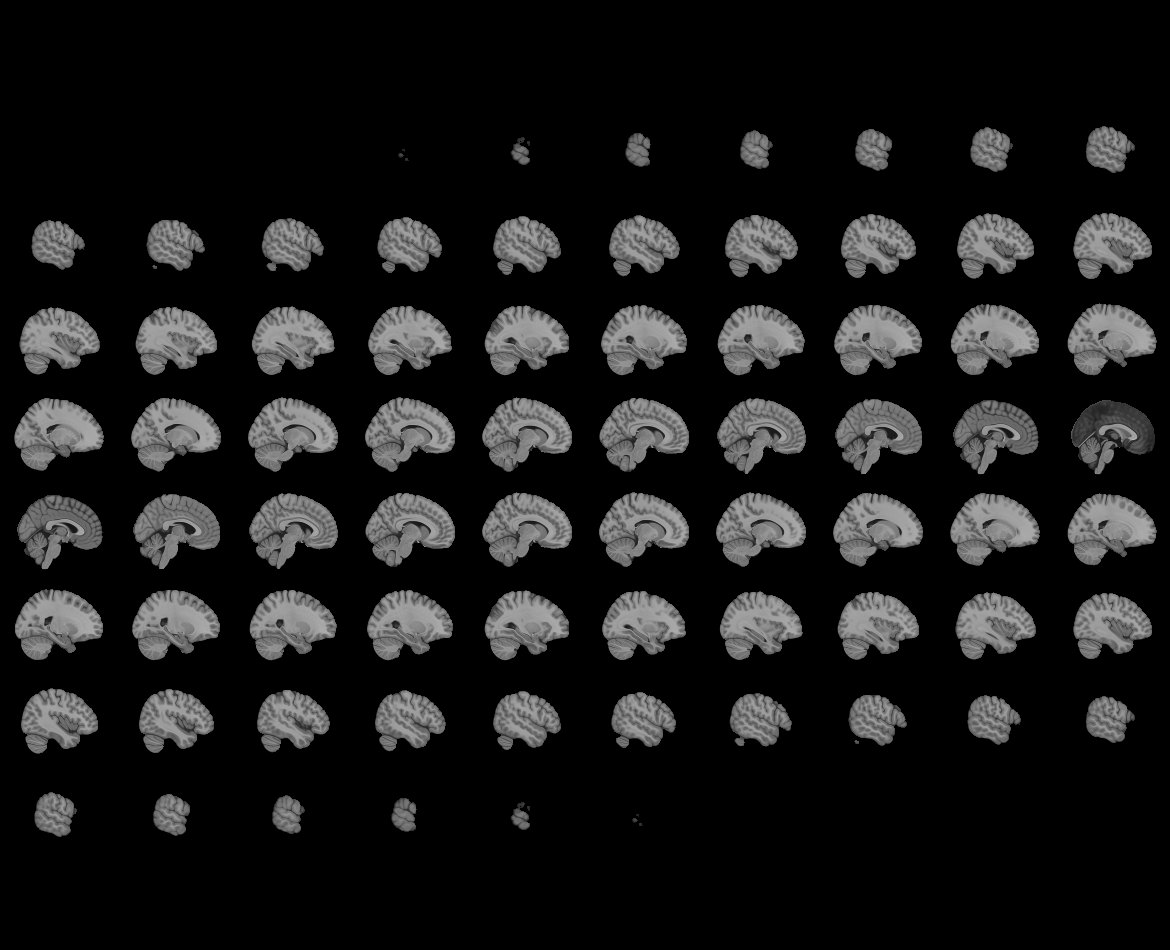
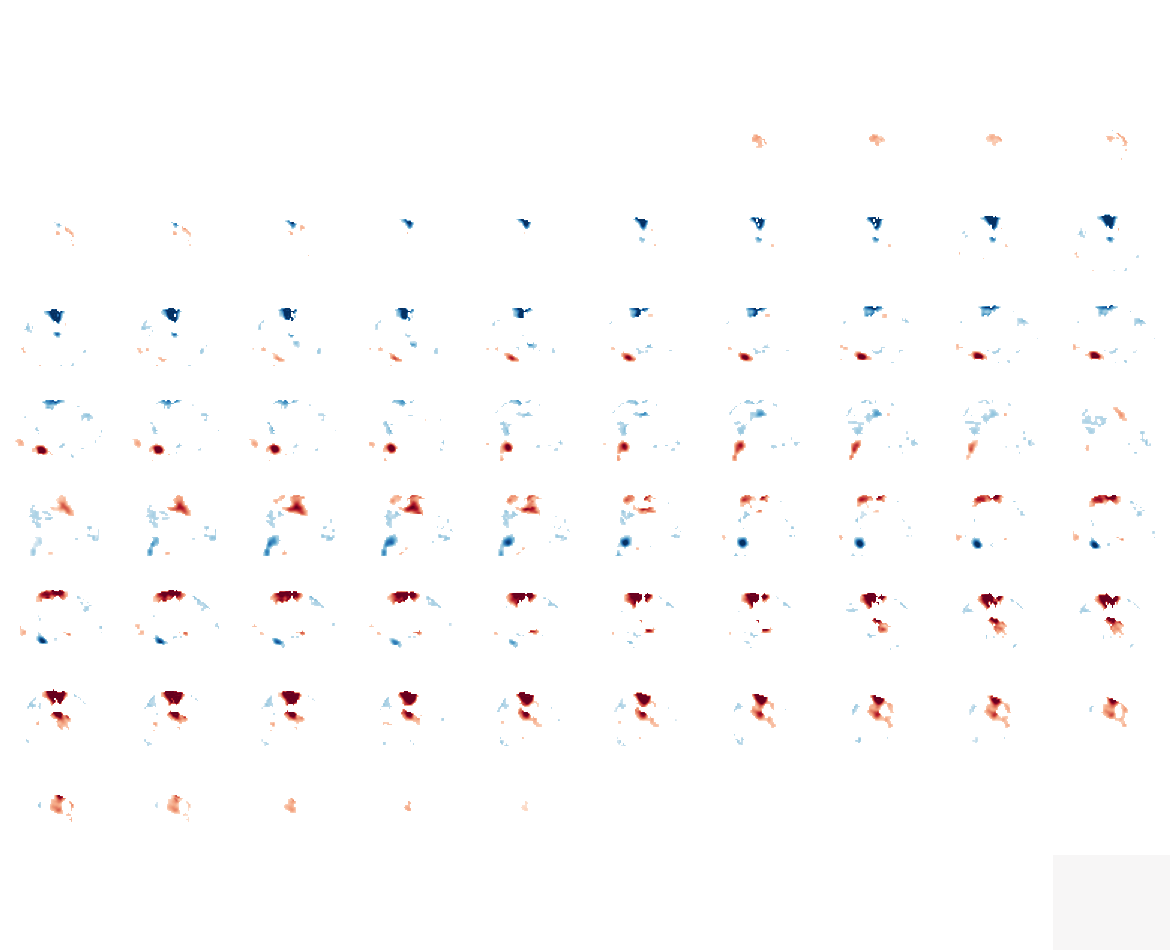

In [6]:
view = plotting.view_img(stat_img, threshold='95%', symmetric_cmap=False)
view

## 4) Simulate a simple 3D connectome in Plotly
We’ll create a small set of nodes and weighted edges and draw them in 3D with interactivity.

In [14]:
# Generate toy nodes & weights (for demo only); threshold edges via quantile; plot edges + colored nodes.
np.random.seed(0)
n_nodes = 10
nodes = np.random.uniform(-50, 50, size=(n_nodes, 3))
A = np.random.rand(n_nodes, n_nodes)
A = (A + A.T)/2
A[A < 0.8] = 0  # sparsify

edge_x, edge_y, edge_z = [], [], []
for a in range(n_nodes):
    for b in range(a+1, n_nodes):
        if A[a, b] > 0:
            x0, y0, z0 = nodes[a]
            x1, y1, z1 = nodes[b]
            edge_x += [x0, x1, None]
            edge_y += [y0, y1, None]
            edge_z += [z0, z1, None]

node_trace = go.Scatter3d(x=nodes[:,0], y=nodes[:,1], z=nodes[:,2],
                          mode='markers', marker=dict(size=6), name='Nodes')
edge_trace = go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines', name='Edges')

fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(title='Simulated 3D Connectome',
                  scene=dict(xaxis=dict(visible=False),
                             yaxis=dict(visible=False),
                             zaxis=dict(visible=False)),
                  showlegend=False, width=800, height=500)
fig.show()

In [8]:
from google.colab import output
output.enable_custom_widget_manager()

## 4) More advanced simulated 3D connectome

Create random node positions and a symmetric weight matrix; threshold by quantile to control density.
Nodes are colored by network; legend shows group names.

In [15]:
# Generate toy nodes & weights (for demo only); threshold edges via quantile; plot edges + colored nodes.
import numpy as np
import plotly.graph_objects as go

np.random.seed(0)
n_nodes = 18

# Random 3D node positions
nodes = np.random.uniform(-60, 60, size=(n_nodes, 3))

# Random symmetric weights, denser than before
A = np.random.rand(n_nodes, n_nodes)
A = (A + A.T) / 2.0
np.fill_diagonal(A, 0.0)

# Keep more edges by using a lower threshold
thr = np.quantile(A[A > 0], 0.75)  # top 25% edges retained
A[A < thr] = 0.0

# Assign nodes to networks (e.g., 3 networks)
networks = np.array(['DMN', 'Salience', 'DorsalAttn'])
node_net = networks[np.random.randint(0, len(networks), size=n_nodes)]

# Build edge coordinates (with thicker lines)
edge_x, edge_y, edge_z = [], [], []
for a in range(n_nodes):
    for b in range(a + 1, n_nodes):
        if A[a, b] > 0:
            x0, y0, z0 = nodes[a]
            x1, y1, z1 = nodes[b]
            edge_x += [x0, x1, None]
            edge_y += [y0, y1, None]
            edge_z += [z0, z1, None]

edge_trace = go.Scatter3d(
    x=edge_x, y=edge_y, z=edge_z,
    mode='lines',
    line=dict(width=3),  # thicker edges
    hoverinfo='none',
    name='Edges'
)

# Separate node traces per network for legend and color
node_traces = []
palette = {
    'DMN': '#1f77b4',
    'Salience': '#ff7f0e',
    'DorsalAttn': '#2ca02c'
}

for net in networks:
    idx = np.where(node_net == net)[0]
    if idx.size == 0:
        continue
    hovertext = [f"Node {i}<br>Network: {net}" for i in idx]
    node_traces.append(
        go.Scatter3d(
            x=nodes[idx,0], y=nodes[idx,1], z=nodes[idx,2],
            mode='markers',
            marker=dict(size=10, color=palette.get(net, '#7f7f7f')),
            name=net,
            hovertext=hovertext,
            hoverinfo='text'
        )
    )

fig = go.Figure(data=[edge_trace] + node_traces)
fig.update_layout(
    title='Advanced 3D Connectome (denser, colored by network)',
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    ),
    showlegend=True,
    width=900, height=600
)
fig.show()

### (Optional) Interactive controls
Use sliders to adjust nodes, edge density (quantile), node size, network count, and canvas size.

In [16]:
# If widgets don't render, use the fallback cell below or re-run setup and restart the runtime.
# Interactive connectome controls (requires ipywidgets)
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except Exception:
    pass

import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact

def draw_connectome(n_nodes=18, edge_quantile=0.75, node_size=10, n_networks=3, canvas=700):
    rng = np.random.default_rng(0)
    nodes = rng.uniform(-60, 60, size=(n_nodes, 3))
    A = rng.random((n_nodes, n_nodes))
    A = (A + A.T) / 2.0
    np.fill_diagonal(A, 0.0)

    # threshold by quantile to keep top (1 - q) fraction
    valid = A[A > 0]
    thr = np.quantile(valid, edge_quantile) if valid.size else 0.0
    A[A < thr] = 0.0

    # assign networks
    labels = np.array(['Net '+str(i+1) for i in range(n_networks)])
    node_net = labels[rng.integers(0, n_networks, size=n_nodes)]

    # edges
    edge_x, edge_y, edge_z = [], [], []
    for a in range(n_nodes):
        for b in range(a + 1, n_nodes):
            if A[a, b] > 0:
                x0, y0, z0 = nodes[a]
                x1, y1, z1 = nodes[b]
                edge_x += [x0, x1, None]
                edge_y += [y0, y1, None]
                edge_z += [z0, z1, None]

    edge_trace = go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        mode='lines', line=dict(width=3), hoverinfo='none', name='Edges'
    )

    # palette (cycle if more networks)
    base_colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd',
                   '#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
    node_traces = []
    for idx, net in enumerate(labels):
        sel = np.where(node_net == net)[0]
        if sel.size == 0:
            continue
        node_traces.append(go.Scatter3d(
            x=nodes[sel,0], y=nodes[sel,1], z=nodes[sel,2],
            mode='markers',
            marker=dict(size=node_size, color=base_colors[idx % len(base_colors)]),
            name=net,
            hovertext=[f"Node {i}<br>Network: {net}" for i in sel],
            hoverinfo='text'
        ))

    fig = go.Figure(data=[edge_trace] + node_traces)
    fig.update_layout(
        title='Interactive 3D Connectome',
        scene=dict(xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False)),
        showlegend=True, width=canvas, height=canvas*0.66
    )
    return fig

_ = interact(
    draw_connectome,
    n_nodes=widgets.IntSlider(value=18, min=6, max=60, step=2, description='Nodes'),
    edge_quantile=widgets.FloatSlider(value=0.75, min=0.5, max=0.95, step=0.01, readout_format='.2f', description='Edge q'),
    node_size=widgets.IntSlider(value=10, min=4, max=20, step=1, description='Node size'),
    n_networks=widgets.IntSlider(value=3, min=2, max=8, step=1, description='Networks'),
    canvas=widgets.IntSlider(value=900, min=500, max=1400, step=50, description='Canvas px')
)

interactive(children=(IntSlider(value=18, description='Nodes', max=60, min=6, step=2), FloatSlider(value=0.75,…

### 5) Upload & visualize your own NIfTI
In Colab, run the next cell and choose a `.nii` or `.nii.gz` file. Then view it interactively. If the interactive viewer fails, a static fallback is used.

Saving PE_T.nii.gz to PE_T.nii.gz


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:820: UserWarning:





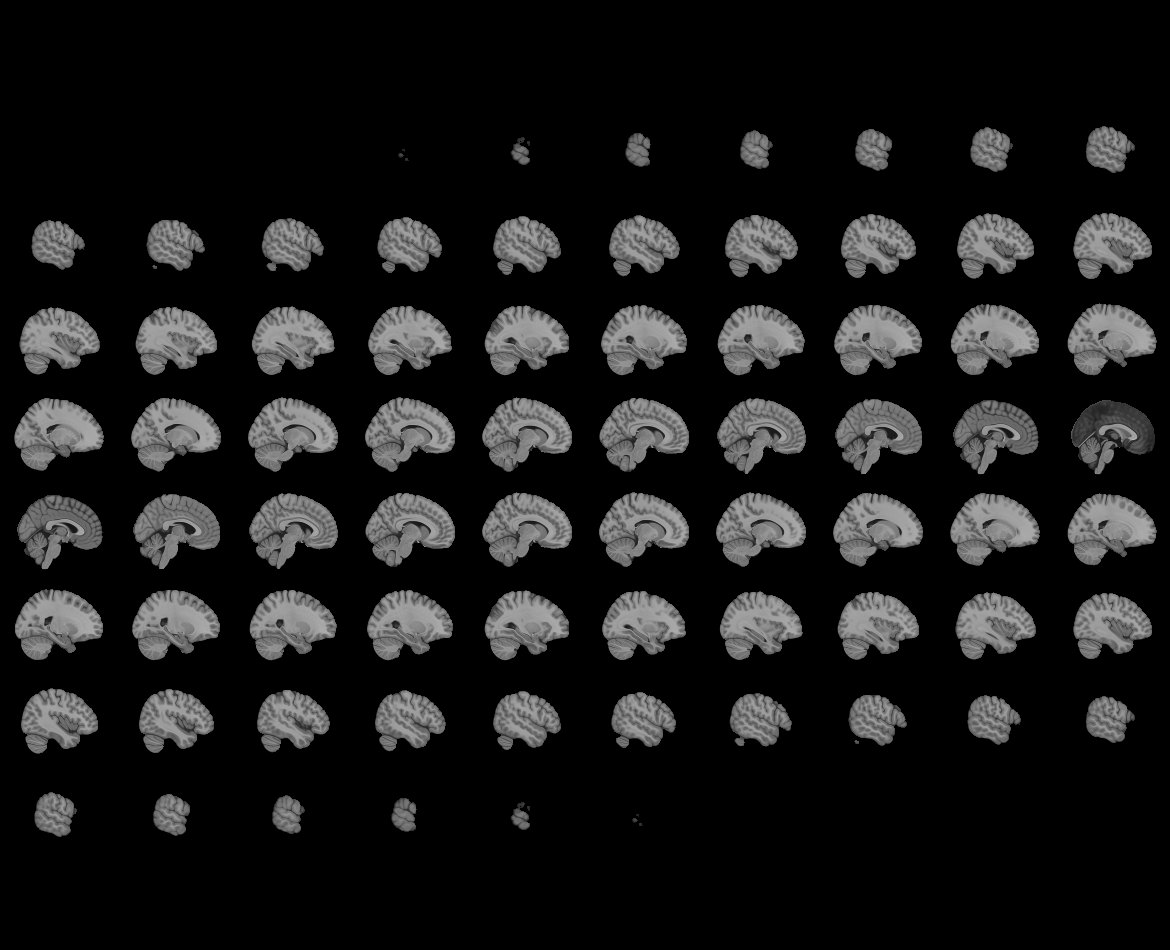
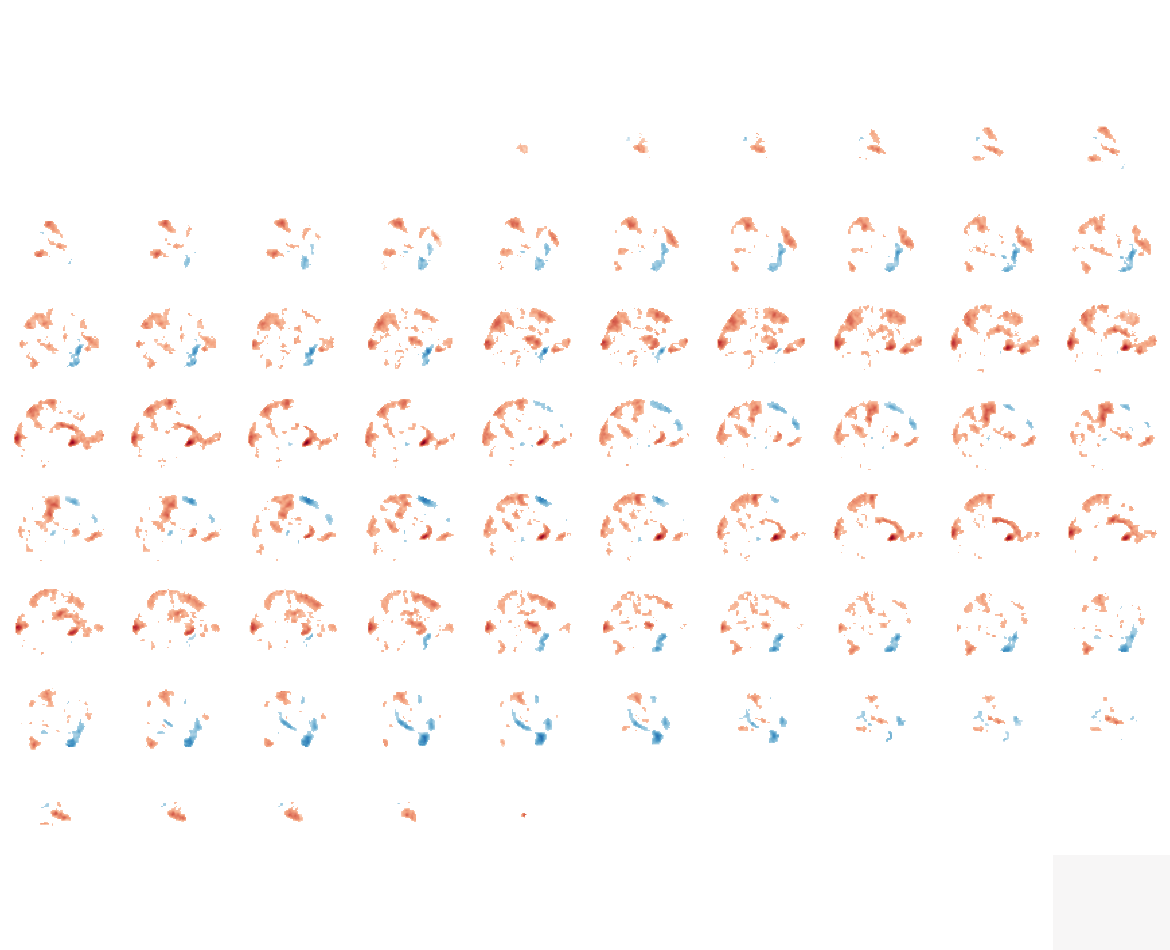

In [12]:
# Colab tip: After installs, restart runtime once; for odd affines/NaNs, try `threshold='auto'` or `None`.
# Downloaded stat images from: https://neurovault.org/collections/21902/ to my local computer.
try:
    from google.colab import files
    uploaded = files.upload()
    upname = list(uploaded.keys())[0]
    img = nib.load(upname)
    view = plotting.view_img(img, threshold='95%')
    display(view)
except Exception as e:
    print('Upload available only in Google Colab. If local, provide a path to your NIfTI and use nibabel to load it.')
    print(e)

## Additional Exercises (pick 1–2)
- Change the hemisphere to **right** and re‑plot the surface.
- Swap the statistical image for another from the NeuroVault motor set.
- Adjust volume rendering parameters (`opacity`, `surface_count`).
- Add **hover text** to nodes in the connectome plot.
- Upload your own map and try different thresholds in `view_img`.

### Bonus: Save figures
```python
fig.write_html('figure.html', include_plotlyjs='cdn')
```


---
If something breaks in Colab due to versions, re‑run the **setup** cell and then `Runtime → Restart runtime`.

## Resources & next steps
- **Nilearn**: plotting & surface utilities, dataset fetchers
- **Nibabel**: load/save NIfTI, inspect headers/affines
- **Plotly**: `Mesh3d`, `Scatter3d`, `Volume` docs
- Export sharable HTML: `fig.write_html('viz.html', include_plotlyjs='cdn')`
- Always note coordinate space (MNI vs native) in figure captions

## Troubleshooting checklist
- **Viewer not showing**: Re-run Setup → *Runtime → Restart runtime* (Colab). Then re-run cells in order.
- **Widgets error (e.g., VBoxModel)**: Ensure `ipywidgets` is installed (pinned in Setup), and run the widgets cell **after** Setup. If still broken, use the **fallback** connectome cell.
- **Blank/flat volume**: Try widening intensity window (e.g., `robust_percentiles(..., lo=80, hi=99.5)`), or set `opacity` higher.
- **Odd orientations**: Check `img.affine`; you may need to `nilearn.image.reorder_img(img)` for consistent display.
- **Big files slow**: Downsample (`image.resample_img`) and keep surfaces/volumes light for teaching.
- **Exporting**: Use `write_html(fig, 'name.html')` to share interactive plots without a notebook.
